In [ ]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [ ]:
import numpy as np
from PIL import Image

In [ ]:
path = Path('/content/drive/MyDrive/Semantic Segmentation')#Change accordingly
path.ls()

[PosixPath('/content/drive/MyDrive/Semantic Segmentation/train'),
 PosixPath('/content/drive/MyDrive/Semantic Segmentation/test')]

In [ ]:
path_img = path/'train/satellite'
path_lbl = path/'train/masks'

In [ ]:
imageFileNames = get_image_files(path_img)
imageFileNames[:5]

[PosixPath('/content/drive/MyDrive/Semantic Segmentation/train/satellite/TN_628600_13.40117784_80.11171289_18.png'),
 PosixPath('/content/drive/MyDrive/Semantic Segmentation/train/satellite/TN_628557_13.49068585_80.14580484_18.png'),
 PosixPath('/content/drive/MyDrive/Semantic Segmentation/train/satellite/TN_628563_13.47954739_80.12746019_18.png'),
 PosixPath('/content/drive/MyDrive/Semantic Segmentation/train/satellite/TN_628598_13.38294703_80.13309578_18.png'),
 PosixPath('/content/drive/MyDrive/Semantic Segmentation/train/satellite/TN_628580_13.41880756_80.02593268_18.png')]

In [ ]:
label_names = get_image_files(path_lbl)
label_names[:5]

[PosixPath('/content/drive/MyDrive/Semantic Segmentation/train/masks/TN_628585_13.42921065_80.13698256_18.png'),
 PosixPath('/content/drive/MyDrive/Semantic Segmentation/train/masks/TN_628681_13.34944804_80.17778543_18.png'),
 PosixPath('/content/drive/MyDrive/Semantic Segmentation/train/masks/TN_628607_13.37070767_79.99594054_18.png'),
 PosixPath('/content/drive/MyDrive/Semantic Segmentation/train/masks/TN_628553_13.48331743_80.02359483_18.png'),
 PosixPath('/content/drive/MyDrive/Semantic Segmentation/train/masks/TN_628563_13.47954739_80.12746019_18.png')]

In [ ]:
get_label_image = lambda x: path_lbl_modified/f'{x.stem}{x.suffix}'
get_original_label_image = lambda x: path_lbl/f'{x.stem}{x.suffix}'

In [ ]:
#Functions to convert multi class segmentations to two class segmentation having 1 as mask for vegetation and 0 for rest
def getClassValues(label_names):

    containedValues = set([])

    for i in range(len(label_names)):
        tmp = open_mask(label_names[i])
        tmp = tmp.data.numpy().flatten()
        tmp = set(tmp)
        containedValues = containedValues.union(tmp)
    
    return list(containedValues)

def replaceMaskValuesFromZeroToN(mask):

    newMask = (np.dot(np.bitwise_xor(mask, np.array([255, 201, 0, 255])), np.array([1, 1, 1, 1]))==0).astype(int)

    #newMask[mask == 194] = 1
    
    return newMask

def convertMaskToPilAndSave(mask, 
                            saveTo):

    imageSize = mask.squeeze().shape

    im = Image.new('L',(imageSize[1],imageSize[0]))
    im.putdata(mask.astype('uint8').ravel())
    im.save(saveTo)

def convertMasksToGrayscaleZeroToN(pathToLabels,
                                   saveToPath):

    label_names = get_image_files(pathToLabels)
    #containedValues = getClassValues(label_names)

    for currentFile in label_names:
        currentMask = np.asarray(Image.open(currentFile))
        convertedMask = replaceMaskValuesFromZeroToN(currentMask)
        convertMaskToPilAndSave(convertedMask, saveToPath/f'{currentFile.name}')
    
    print('Conversion finished!')


In [ ]:
path_lbl_modified = path/'train/masks_new'
#convertMasksToGrayscaleZeroToN(path_lbl, path_lbl_modified)

In [ ]:
len(get_image_files(path_lbl_modified))

441

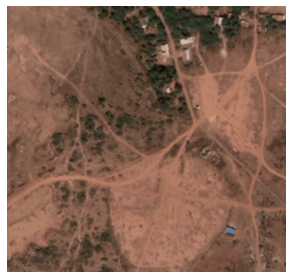

In [ ]:
img_f = imageFileNames[8]
img = open_image(img_f)
img.show(figsize=(5,5))

(None, torch.Size([1, 1948, 2048]))

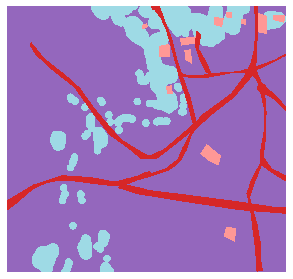

In [ ]:
label_img_path = get_original_label_image(img_f)
mask = open_mask(label_img_path)
mask.show(figsize=(5,5), alpha=1), mask.data.shape

(None, torch.Size([1, 1948, 2048]))

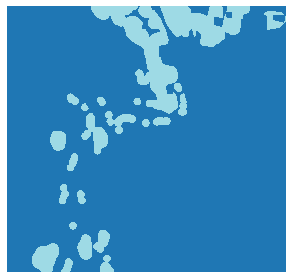

In [ ]:
label_img_path = get_label_image(img_f)
mask = open_mask(label_img_path)
mask.show(figsize=(5,5), alpha=1), mask.data.shape

In [ ]:
codes = np.array(['no vegetation','vegetation'])

In [ ]:
#size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 16157MB of GPU RAM free


In [ ]:
src = (SegmentationItemList
       .from_folder(path_img)
       .split_by_rand_pct()
       .label_from_func(get_label_image, classes=codes)
       )

In [ ]:
data = (src.transform(get_transforms(), size=512, tfm_y=True)
        .databunch(bs=bs, num_workers=0)
        .normalize(imagenet_stats))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3503: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3503: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3500: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3500: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

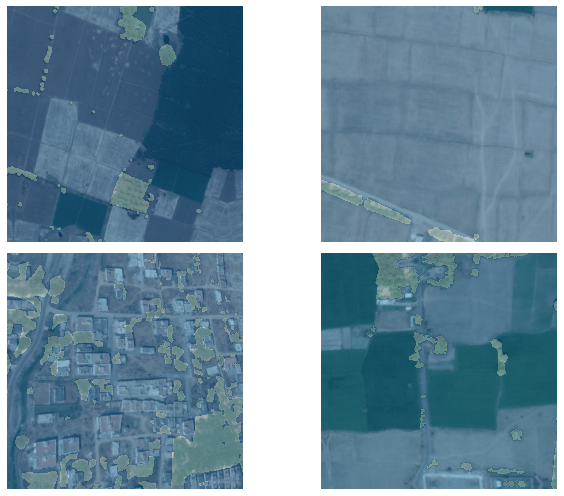

In [ ]:
data.show_batch(2, figsize=(10,7))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3500: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3500: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

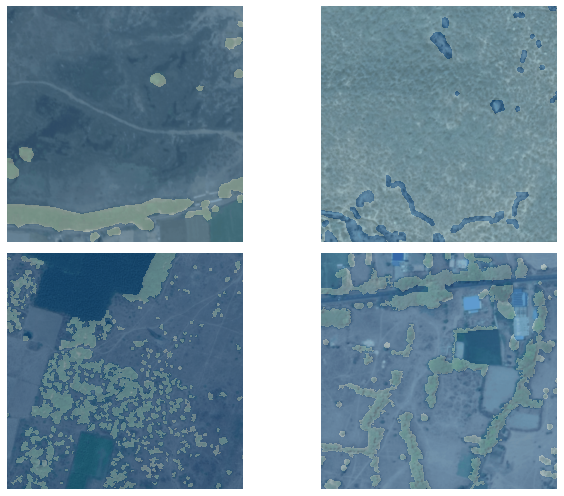

In [ ]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

In [ ]:
def IoU(preds:Tensor, targs:Tensor, eps:float=1e-8):
    """Computes the Jaccard loss, a.k.a the IoU loss.
    Notes: [Batch size,Num classes,Height,Width]
    Args:
        targs: a tensor of shape [B, H, W] or [B, 1, H, W].
        preds: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model. (prediction)
        eps: added to the denominator for numerical stability.
    Returns:
        iou: the average class intersection over union value 
             for multi-class image segmentation
    """
    num_classes = preds.shape[1]
    
    # Single class segmentation
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[targs.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(preds)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
        
    # Multi-class segmentation
    else:
        # Convert target to one-hot encoding
        # true_1_hot = torch.eye(num_classes)[torch.squeeze(targs,1)]
        true_1_hot = torch.eye(num_classes)[targs.squeeze(1)]
        
        # Permute [B,H,W,C] to [B,C,H,W]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        
        # Take softmax along class dimension; all class probs add to 1 (per pixel)
        probas = F.softmax(preds, dim=1)
        
    true_1_hot = true_1_hot.type(preds.type())
    
    # Sum probabilities by class and across batch images
    dims = (0,) + tuple(range(2, targs.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims) # [class0,class1,class2,...]
    cardinality = torch.sum(probas + true_1_hot, dims)  # [class0,class1,class2,...]
    union = cardinality - intersection
    iou = (intersection / (union + eps)).mean()   # find mean of class IoU values
    return iou

In [ ]:
metrics=IoU
wd=1e-2

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3503: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


In [ ]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3503: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3503: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


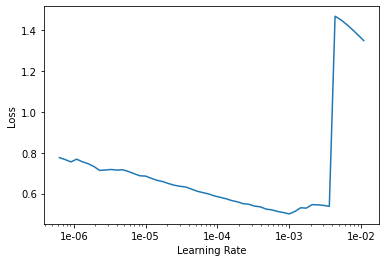

In [ ]:
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr=5e-5
learn.fit_one_cycle(80, slice(lr), pct_start=0.9)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3503: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3503: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default

In [ ]:
learn.save('/content/drive/MyDrive/stage-1')

In [ ]:
learn.load('/content/drive/MyDrive/stage-1')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3500: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3500: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

Learner(data=ImageDataBunch;

Train: LabelList (353 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: /content/drive/MyDrive/Semantic Segmentation/train/satellite;

Valid: LabelList (88 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: /content/drive/MyDrive/Semantic Segmentation/train/satellite;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momen

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3503: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3503: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

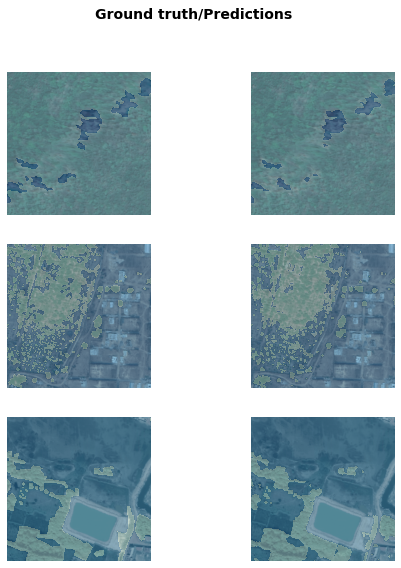

In [ ]:
learn.show_results(rows=3, figsize=(8,9))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3503: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3503: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


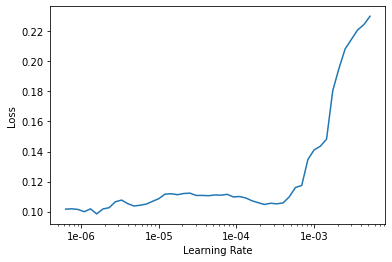

In [ ]:
learn.unfreeze()
lr_find(learn)
learn.recorder.plot()

In [ ]:
lr = 7e-5
lrs = slice(3e-5,lr/5)
learn.fit_one_cycle(10, lrs)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3503: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3503: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default

In [ ]:
learn.save('/content/drive/MyDrive/stage-4')

In [ ]:
learn.load('/content/drive/MyDrive/stage-4(2)')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3503: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3503: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

Learner(data=ImageDataBunch;

Train: LabelList (353 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: /content/drive/MyDrive/Semantic Segmentation/train/satellite;

Valid: LabelList (88 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: /content/drive/MyDrive/Semantic Segmentation/train/satellite;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momen

In [ ]:
test_path_img = path/'test/satellite'
preds_path_img = path/'test/preds'

In [ ]:
imageFileNames = get_image_files(test_path_img)
imageFileNames[:5]

[PosixPath('/content/drive/MyDrive/Semantic Segmentation/test/satellite/TN_632298_12.39500866_79.42634056_18.png'),
 PosixPath('/content/drive/MyDrive/Semantic Segmentation/test/satellite/TN_632269_12.4309812_79.29519495_18.png'),
 PosixPath('/content/drive/MyDrive/Semantic Segmentation/test/satellite/TN_632293_12.38275675_79.35575685_18.png'),
 PosixPath('/content/drive/MyDrive/Semantic Segmentation/test/satellite/TN_632258_12.05348273_79.18293543_18.png'),
 PosixPath('/content/drive/MyDrive/Semantic Segmentation/test/satellite/TN_632313_12.35000383_79.25107394_18.png')]

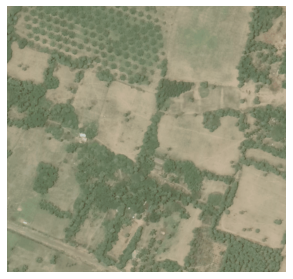

In [ ]:
img_f = imageFileNames[30]
img = open_image(img_f)
img.show(figsize=(5,5))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3500: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


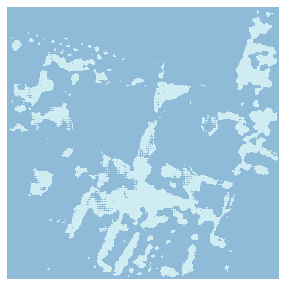

In [ ]:
learn.predict(img)[0].show(figsize=(5,5))

In [ ]:
for imageFileName in imageFileNames:#Loop to predict mask for each test image and save in preds
  img = open_image(imageFileName)
  img.resize(512)
  mask_pred = learn.predict(img)
  mask_pred[0].save(str(preds_path_img)+'/'+str(imageFileName).split('/')[-1])

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3503: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3503: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

In [ ]:
imageFileNames = get_image_files(preds_path_img)
len(imageFileNames)

50

In [ ]:
preds_resized_path_img = path/'test/preds_resized'
for imageFileName in imageFileNames:#Loop to resize the predicted to 1948*2048 and store in preds_resized
  mask = open_mask(imageFileName)
  mask = mask.resize(torch.Size([mask.shape[0],1948, 2048])).refresh()
  mask.save(str(preds_resized_path_img)+'/'+str(imageFileName).split('/')[-1])

In [ ]:
imageFileNames = get_image_files(preds_resized_path_img)
len(imageFileNames)

50

In [ ]:
import pandas as pd
df  = pd.read_csv('/content/drive/MyDrive/Semantic Segmentation/test/Sample Submission.csv')
df.head()

ImageId EncodedPixels
0        TN_632663_12.17698923_79.74434127_18.png           1 1
1         TN_632269_12.4309812_79.29519495_18.png           1 1
2        TN_632589_12.22150005_79.86395921_18.png           1 1
3        TN_632406_12.25225177_79.47212711_18.png           1 1
4  TN_632592_12.17579518_79.89499740000002_18.png           1 1

In [ ]:
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = torch.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend(((b+1).item(), 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

In [ ]:
for index, row in df.iterrows():#Iterate over each row in dataframe and store rle encoding for each test image
  path = preds_resized_path_img/row['ImageId']
  mask = open_mask(path)
  encoding = rle_encoding(mask.data.squeeze(0))
  row['EncodedPixels'] = ' '.join([str(elem) for elem in encoding])

In [ ]:
df.to_csv('Submission.csv', index=False)